# Verzögerungen in der Entwicklung

Diese Analyse beschäftigt sich mit der Darstellung von Verzögerungen im Entwicklungsprozess.
Dazu wird für abgeschlossene Aufgaben dargestellt, wie viele Sprints dafür in Anspruch genommen wurden und welches Code Ownership zu diesem Zeitpunkt dort vorhanden war.

## Laden relevanter Daten aus der Datenbank

Als erster Schritt werden die für die Analyse relevanten Daten aus der Datenbank geladen. Es werden Entwicklungen in den Teilkomponenten berücksichtigt, welche auf eine Aufgabe im Scrum-Prozess verweisen. Für diese wird dargestellt, in wie vielen Sprints sie aufgenommen wurde und welches Code Ownership vorlag.

Das Code Ownership wird anhand der Anzahl der Commits und geänderten Codezeilen berechnet.
Die entsprechende Formel zu Berechnung des Anteils einer einzelnen Person $P$ zum Zeitpunkt $t$ lautet: 

$
\textrm{Ownership}(P)_t = 
    \frac{
        \frac{\textrm{Commits}(p)_t}{\textrm{Commits} _t}
        +\frac{\textrm{LoCC}(p)_t}{\textrm{LoCC} _t}
    }
    {2}
$

Das Code-Ownership des Teilprojekts ist der maximale Wert aus der Liste der persönlichen Anteile der Beteiligten.

In [1]:
import shared.paths as paths
import shared.locals as locals
from tinydb.queries import where
from datetime import datetime
from database.models import Merge, Story
from database.database import Database
from shared.calculation import query_and_calculate_ownership, average

database = Database(paths.DATABASE_PATH, cached=True)

results = {}

for merge in database.query(Merge.LABEL, where("story_id") != None):
    story = database.query(Story.LABEL, where("id") == merge.story_id)[0]
    sprints = len(story.sprints)
    ownership = query_and_calculate_ownership(database, merge.project_id, merge.timestamp)

    results[datetime.utcfromtimestamp(merge.timestamp)] = {
        "sprints": sprints,
        "ownership": ownership
    }

    results = dict(sorted(results.items()))

## Visualisierung der Daten

Im zweiten Schritt werden die Daten anhand eines modifizierten Streudiagramms dargestellt. Zusätzlich wird der Mittelwerte des Code Ownerships pro Sprintdauer anhand einer Linie visualisiert.

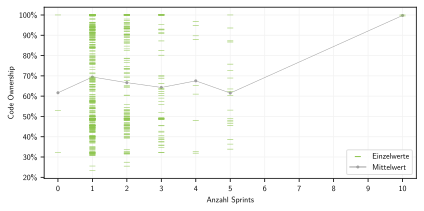

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Einzelwerte
plt.rc("font", **locals.FONT)
fig, ax = plt.subplots(figsize=(locals.TEXTWIDTH, 3))

sprints = [results[dt]["sprints"] for dt in results.keys()]
ownership = [results[dt]["ownership"] for dt in results.keys()]

ax.scatter(sprints, ownership, color=locals.MATERIAL_COLORS["lightgreen"], marker="_",
    linewidths=0.5, zorder=2, label="Einzelwerte")

# Durchschnitt pro Anzahl an Sprints
ownership_overview = {sprint: [] for sprint in range(max(sprints)+1)}

for result in results.values():
    ownership_overview[result["sprints"]].append(result["ownership"])

averages = {}

for sprint, values in ownership_overview.items():
    if values:
        averages[sprint] = average(values)

ax.plot(list(averages.keys()), list(averages.values()), zorder=1,
    color=locals.MATERIAL_COLORS["gray"], linewidth=0.5, marker=".", markersize=4, label="Mittelwert")

legend = ax.legend(loc="lower right", edgecolor=locals.FRAME_GRAY)
for handle in legend.legendHandles:
    handle.set_linewidth(1)

ax.xaxis.set_major_locator(mticker.MultipleLocator(1.0))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

ax.margins(x=0.04)
ax.set_xlabel("Anzahl Sprints")
ax.set_ylabel("Code Ownership")
ax.grid(color=locals.GRID_GRAY)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

## Erstellung der Wertetabellen

Als letzter Schritt werden entsprechende Wertetabelle angelegt. Diese unterteilen sich in Wertetabellen zur Übersicht der Daten und zu den genauen Werten.

In [3]:
import math
from IPython.display import display, HTML, Markdown
from tabulate import tabulate

display(Markdown("**Übersichtstabelle**"))

distinct_sprints = set(sprints)
table_headers = ["Bereich"]
table_headers.extend([f"{i} Sprint" if i == 1 else f"{i} Sprints" for i in distinct_sprints])
table_rows = []

categories = {i: {sprint: 0 for sprint in distinct_sprints} for i in range(10,101,10)}

for result in results.values():
    category = int(math.ceil(result["ownership"] * 10.0) * 10.0)
    categories[category][result["sprints"]] += 1

for category in categories.keys():
    row = [f"{category-10 if category == 10 else category-9}-{category} %"]
    row.extend(categories[category].values())
    table_rows.append(row)

sum_row = ["Summe"]
for i in range(1, len(table_headers)):
    sum_row.append(sum([row[i] for row in table_rows]))
table_rows.append(sum_row)

display(HTML(tabulate(headers=table_headers,
    tabular_data=table_rows,
    tablefmt="html", stralign="center", numalign="center")))


display(Markdown("**Durchschnittliches Code-Ownership**"))

table_headers = ["Anzahl Sprints", "Mittelwert Code-Ownership"]
table_rows = [[sprints, f"{ownership:.2f}"] for sprints, ownership in averages.items()]

display(HTML(tabulate(
    headers=table_headers,
    tabular_data=table_rows,
    tablefmt="html", stralign="center", numalign="center"
)))


display(Markdown("**Wertetabelle**"))

table_headers = ["Anzahl Sprints", "Ownership"]
compact_result = {sprint: [] for sprint in distinct_sprints}

for result in results.values():
    compact_result[result["sprints"]].append(f"{result['ownership']:.2f}")

for sprint, values in compact_result.items():
    distinct_ownership = sorted(list(set(sorted(values))))
    compact_result[sprint] = ", ".join([f"{ownership} ({values.count(ownership)})" for ownership in distinct_ownership])

table_rows = [[sprint, value] for sprint, value in compact_result.items()]

display(HTML(tabulate(headers=table_headers,
    tabular_data=table_rows,
    tablefmt="html", stralign="center", numalign="center")))


display(Markdown("**Auflistung anhand des Datums**"))

table_headers = ["Datum", "Anzahl Sprints", "Ownership"]
table_rows = []

for dt, result in results.items():
    table_rows.append([
        dt.strftime("%d.%m.%Y"),
        result["sprints"],
        f"{result['ownership']:.2f}"
    ])

display(HTML(tabulate(headers=table_headers,
    tabular_data=table_rows,
    tablefmt="html", stralign="center", numalign="center")))

**Übersichtstabelle**

Bereich,0 Sprints,1 Sprint,2 Sprints,3 Sprints,4 Sprints,5 Sprints,10 Sprints
0-10 %,0,0,0,0,0,0,0
11-20 %,0,0,0,0,0,0,0
21-30 %,0,2,2,0,0,0,0
31-40 %,1,40,10,10,2,3,0
41-50 %,0,84,37,14,1,5,0
51-60 %,1,42,11,4,0,1,0
61-70 %,0,27,8,8,2,4,0
71-80 %,0,21,10,1,0,2,0
81-90 %,0,33,11,3,2,2,0
91-100 %,1,123,35,15,2,2,2


**Durchschnittliches Code-Ownership**

Anzahl Sprints,Mittelwert Code-Ownership
0,0.62
1,0.69
2,0.67
3,0.64
4,0.68
5,0.62
10,1


**Wertetabelle**

Anzahl Sprints,Ownership
0,"0.32 (1), 0.53 (1), 1.00 (1)"
1,"0.23 (1), 0.26 (1), 0.31 (5), 0.32 (10), 0.33 (3), 0.34 (4), 0.35 (2), 0.37 (3), 0.38 (4), 0.39 (5), 0.40 (9), 0.41 (2), 0.42 (2), 0.43 (7), 0.44 (10), 0.45 (12), 0.46 (7), 0.47 (2), 0.48 (10), 0.49 (25), 0.50 (10), 0.51 (1), 0.52 (3), 0.53 (2), 0.54 (6), 0.55 (3), 0.56 (1), 0.57 (7), 0.58 (6), 0.59 (2), 0.60 (3), 0.61 (2), 0.62 (1), 0.63 (4), 0.64 (1), 0.65 (3), 0.66 (3), 0.67 (4), 0.68 (5), 0.69 (4), 0.71 (2), 0.73 (1), 0.74 (1), 0.75 (1), 0.76 (5), 0.77 (2), 0.78 (4), 0.79 (3), 0.80 (3), 0.81 (1), 0.82 (1), 0.83 (3), 0.84 (5), 0.85 (6), 0.86 (1), 0.87 (3), 0.88 (5), 0.89 (3), 0.90 (7), 0.91 (8), 0.92 (5), 0.93 (8), 0.94 (10), 0.95 (6), 0.96 (6), 0.98 (2), 0.99 (2), 1.00 (73)"
2,"0.26 (1), 0.27 (1), 0.31 (1), 0.32 (4), 0.33 (1), 0.34 (1), 0.39 (1), 0.40 (3), 0.41 (2), 0.42 (2), 0.43 (1), 0.44 (5), 0.45 (4), 0.46 (4), 0.47 (1), 0.48 (4), 0.49 (10), 0.50 (4), 0.51 (3), 0.52 (2), 0.53 (2), 0.54 (2), 0.56 (1), 0.60 (2), 0.64 (1), 0.65 (2), 0.68 (1), 0.69 (1), 0.70 (1), 0.71 (1), 0.72 (1), 0.73 (2), 0.74 (1), 0.75 (1), 0.77 (1), 0.78 (1), 0.79 (2), 0.83 (2), 0.85 (1), 0.86 (1), 0.87 (3), 0.88 (1), 0.89 (2), 0.90 (5), 0.91 (1), 0.92 (2), 0.93 (5), 0.94 (4), 0.95 (2), 0.96 (3), 0.97 (1), 0.98 (1), 1.00 (12)"
3,"0.32 (2), 0.35 (1), 0.36 (2), 0.37 (1), 0.38 (1), 0.39 (2), 0.40 (1), 0.41 (1), 0.42 (1), 0.43 (1), 0.45 (1), 0.46 (1), 0.48 (2), 0.49 (7), 0.52 (1), 0.56 (1), 0.57 (1), 0.59 (1), 0.60 (1), 0.61 (1), 0.62 (1), 0.63 (1), 0.64 (1), 0.66 (1), 0.69 (2), 0.70 (1), 0.80 (1), 0.83 (1), 0.87 (1), 0.91 (2), 0.93 (3), 0.95 (1), 1.00 (9)"
4,"0.32 (1), 0.33 (1), 0.48 (1), 0.61 (1), 0.65 (1), 0.88 (1), 0.90 (1), 0.95 (1), 0.97 (1)"
5,"0.34 (1), 0.36 (1), 0.39 (1), 0.46 (1), 0.47 (2), 0.48 (1), 0.49 (1), 0.53 (1), 0.60 (1), 0.62 (1), 0.64 (1), 0.69 (1), 0.73 (1), 0.76 (1), 0.87 (2), 0.94 (1), 1.00 (1)"
10,1.00 (2)


**Auflistung anhand des Datums**

Datum,Anzahl Sprints,Ownership
11.05.2020,2,0.51
11.05.2020,2,1
12.05.2020,1,1
15.05.2020,1,0.65
18.05.2020,1,1
28.05.2020,2,0.73
08.06.2020,1,0.74
08.06.2020,1,1
08.06.2020,1,1
12.06.2020,3,1
